# Clustering analysis file

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
!pip install pyreadstat
!pip install kneed

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.1/620.1 kB 8.1 MB/s eta 0:00:00


#Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
base_path = '/content/drive/My Drive/Group 4'

#which cycle to look at
cycle_folder = 'NHANES 2015-2016 data'

#file name to check metadata for
file_name = 'DEMO_I.xpt'

#Construct full path
full_path = os.path.join(base_path, cycle_folder, file_name)


In [ ]:
#Checking if file path is correct
print(full_path)
print(os.listdir(base_path))
print(os.listdir(os.path.join(base_path, cycle_folder)))

/content/drive/My Drive/Group 4/NHANES 2015-2016 data/MCQ_I.xpt
['NHANES 2013-2014 data', 'NHANES 2015-2016 data', 'NHANES 2017-2018 data', 'Group 4 Project Presentation- July 3rd.gslides', 'Project update-July 10th.gslides', '7 17 25 Group 4 Update.gslides', 'EDA.ipynb', 'EDA results.gdoc', 'Group 4 Final Project Draft - 7 24 25.gslides', 'Data Dictionary.gsheet', 'Group4 AIcolab Project.ipynb', 'Cluster.ipynb']
['DEMO_I.xpt', 'BPX_I.xpt', 'TCHOL_I.xpt', 'HDL_I.xpt', 'PFAS_I.xpt', 'PHTHTE_I.xpt', 'MCQ_I.xpt']


#Extract metadata to try and decide which columns to keep or get rid of for clustering

In [ ]:
#Code to read metadata
import pyreadstat

_, meta = pyreadstat.read_xport(full_path)

print(meta.column_names_to_labels)

{'SEQN': 'Respondent sequence number', 'SDDSRVYR': 'Data release cycle', 'RIDSTATR': 'Interview/Examination status', 'RIAGENDR': 'Gender', 'RIDAGEYR': 'Age in years at screening', 'RIDAGEMN': 'Age in months at screening - 0 to 24 mos', 'RIDRETH1': 'Race/Hispanic origin', 'RIDRETH3': 'Race/Hispanic origin w/ NH Asian', 'RIDEXMON': 'Six month time period', 'RIDEXAGM': 'Age in months at exam - 0 to 19 years', 'DMQMILIZ': 'Served active duty in US Armed Forces', 'DMQADFC': 'Served in a foreign country', 'DMDBORN4': 'Country of birth', 'DMDCITZN': 'Citizenship status', 'DMDYRSUS': 'Length of time in US', 'DMDEDUC3': 'Education level - Children/Youth 6-19', 'DMDEDUC2': 'Education level - Adults 20+', 'DMDMARTL': 'Marital status', 'RIDEXPRG': 'Pregnancy status at exam', 'SIALANG': 'Language of SP Interview', 'SIAPROXY': 'Proxy used in SP Interview?', 'SIAINTRP': 'Interpreter used in SP Interview?', 'FIALANG': 'Language of Family Interview', 'FIAPROXY': 'Proxy used in Family Interview?', 'FIAI

# Remove the redundant features by identifying Key Biomarkers in each xpt file

Purpose in this is to try and reduce noise and make clustering as accurate as possible by only keeping the key features we really want to investigate. So getting rid of features like comment codes and keeping features that are actual measurements.

In [ ]:
#PFAS biomarkers
pfas_features = [
    'LBXPFDE','LBXPFHS','LBXMPAH','LBXPFNA','LBXPFUA','LBXPFDO','LBXNFOA','LBXBFOA','LBXNFOS','LBXMFOS'
]

#PHTHTE biomarkers
phthalate_features = ['URXCNP', 'URXCOP', 'URXECP', 'URXHIBP', 'URXMBP',
    'URXMC1', 'URXMCOH', 'URXMEP', 'URXMHBP', 'URXMHH',
    'URXMHNC', 'URXMHP', 'URXMIB', 'URXMNP', 'URXMOH', 'URXMZP']

#HDL biomarkers
hdl_features = ['LBDHDD']

#TCHOL biomarkers
tchol_features = ['LBXTC']

#BPX biomarkers
bpx_features = [
    'BPXCHR',   # Heart rate (60 sec)
    'BPXSY1',   # Systolic BP (1st reading)
    'BPXDI1',   # Diastolic BP (1st reading)
    'BPXSY2',   # Systolic BP (2nd reading)
    'BPXDI2',   # Diastolic BP (2nd reading)
    'BPXSY3',   # Systolic BP (3rd reading)
    'BPXDI3',   # Diastolic BP (3rd reading)
    'BPXSY4',   # Systolic BP (4th reading)
    'BPXDI4'    # Diastolic BP (4th reading)
]

mcq_heart_features = [
    'MCQ160B',  # Congestive heart failure
    'MCQ160C',  # Doctor ever told you had coronary heart disease - Added this back
    'MCQ160D',  # Angina
    'MCQ160E',  # Heart attack
    'MCQ160F',  # Stroke
    'MCQ300A',  # Family history of heart attack
]

#demographic_features = [
   # 'RIAGENDR',  # Gender
   # 'RIDAGEYR',  # Age
   # 'RIDRETH3',  # Race/ethnicity
   # 'DMDBORN4', #Country of birth
   # 'DMDEDUC2', #Educational level
   # 'DMDMARTL', #Marital status
   # 'DMDHHSIZ', #Household size
   # 'DMDHHSZE', #Adults 60+ in household
   # 'DMDHRGND', #Gender of household reference person
   # 'INDFMPIR' #Ratio of family income to poverty
#]

# Load and merge data from group folder

In [ ]:
cycles = ['NHANES 2013-2014 data', 'NHANES 2015-2016 data', 'NHANES 2017-2018 data']

# Feature lists from previous steps
pfas_features = [
    'LBXPFDE', 'LBXPFHS', 'LBXMPAH', 'LBXPFNA', 'LBXPFUA',
    'LBXPFDO', 'LBXNFOA', 'LBXBFOA', 'LBXNFOS', 'LBXMFOS'
]

phthalate_features = [
    'URXCNP', 'URXCOP', 'URXECP', 'URXHIBP', 'URXMBP',
    'URXMC1', 'URXMCOH', 'URXMEP', 'URXMHBP', 'URXMHH',
    'URXMHNC', 'URXMHP', 'URXMIB', 'URXMNP', 'URXMOH', 'URXMZP'
]

hdl_features = ['LBDHDD']

tchol_features = ['LBXTC']

bpx_features = [
    'BPXCHR', 'BPXSY1', 'BPXDI1', 'BPXSY2', 'BPXDI2',
    'BPXSY3', 'BPXDI3', 'BPXSY4', 'BPXDI4'
]

mcq_heart_features = [
    'MCQ160B',  # Congestive heart failure
    'MCQ160C',  # Doctor ever told you had coronary heart disease - Added this back
    'MCQ160D',  # Angina
    'MCQ160E',  # Heart attack
    'MCQ160F',  # Stroke
    'MCQ300A',  # Family history of heart attack
]

#demographic_features = [
    #'RIAGENDR',  # Gender
    #'RIDAGEYR',  # Age
    #'RIDRETH3',  # Race/ethnicity
    #'DMDBORN4', #Country of birth
    #'DMDEDUC2', #Educational level
    #'DMDMARTL', #Marital status
    #'DMDHHSIZ', #Household size
    #'DMDHHSZE', #Adults 60+ in household
    #'DMDHRGND', #Gender of household reference person
    #'INDFMPIR' #Ratio of family income to poverty
#]

# Map files with correct suffix letters and lowercase extensions
file_map = {
    'NHANES 2013-2014 data': {
        'PFAS': 'PFAS_H.xpt',
        'PHTHTE': 'PHTHTE_H.xpt',
        'HDL': 'HDL_H.xpt',
        'TCHOL': 'TCHOL_H.xpt',
        'BPX': 'BPX_H.xpt',
        'MCQ': 'MCQ_H.xpt',
    },
    'NHANES 2015-2016 data': {
        'PFAS': 'PFAS_I.xpt',
        'PHTHTE': 'PHTHTE_I.xpt',
        'HDL': 'HDL_I.xpt',
        'TCHOL': 'TCHOL_I.xpt',
        'BPX': 'BPX_I.xpt',
        'MCQ': 'MCQ_I.xpt',
    },
    'NHANES 2017-2018 data': {
        'PFAS': 'PFAS_J.xpt',
        'PHTHTE': 'PHTHTE_J.xpt',
        'HDL': 'HDL_J.xpt',
        'TCHOL': 'TCHOL_J.xpt',
        'BPX': 'BPX_J.xpt',
        'MCQ': 'MCQ_J.xpt',
    }
}


# Mapping file type to feature list
feature_lookup = {
    'PFAS': pfas_features,
    'PHTHTE': phthalate_features,
    'HDL': hdl_features,
    'TCHOL': tchol_features,
    'BPX': bpx_features,
    'MCQ': mcq_heart_features,
}

# Begin loading
dfs = []

for cycle in cycles:
    dfs_cycle = []
    files_for_cycle = file_map[cycle]

    for file_key, file_name in files_for_cycle.items():
        full_path = os.path.join(base_path, cycle, file_name)
        print(f'Loading {full_path} ...')
        try:
            df, meta = pyreadstat.read_xport(full_path)
        except Exception as e:
            print(f'Error reading {file_name}: {e}')
            continue

        feature_list = feature_lookup[file_key]
        available_features = ['SEQN'] + [f for f in feature_list if f in df.columns]
        df_sub = df[available_features]
        dfs_cycle.append(df_sub)

    if dfs_cycle:
        merged_cycle = reduce(lambda left, right: pd.merge(left, right, on='SEQN', how='inner'), dfs_cycle)
        merged_cycle['cycle'] = cycle
        dfs.append(merged_cycle)

# Combine all cycles
combined_df = pd.concat(dfs, ignore_index=True)

# Optional: final feature list + 'SEQN' + 'cycle' to order columns
final_features = ['SEQN'] + pfas_features + phthalate_features + hdl_features + tchol_features + bpx_features + mcq_heart_features + ['cycle']
final_features = [col for col in final_features if col in combined_df.columns]  # drop ones not in data
combined_df = combined_df[final_features]

print('Merged data shape:', combined_df.shape)
combined_df.head()

Loading /content/drive/My Drive/Group 4/NHANES 2013-2014 data/PFAS_H.xpt ...
Loading /content/drive/My Drive/Group 4/NHANES 2013-2014 data/PHTHTE_H.xpt ...
Loading /content/drive/My Drive/Group 4/NHANES 2013-2014 data/HDL_H.xpt ...
Loading /content/drive/My Drive/Group 4/NHANES 2013-2014 data/TCHOL_H.xpt ...
Loading /content/drive/My Drive/Group 4/NHANES 2013-2014 data/BPX_H.xpt ...
Loading /content/drive/My Drive/Group 4/NHANES 2013-2014 data/MCQ_H.xpt ...
Loading /content/drive/My Drive/Group 4/NHANES 2015-2016 data/PFAS_I.xpt ...
Loading /content/drive/My Drive/Group 4/NHANES 2015-2016 data/PHTHTE_I.xpt ...
Loading /content/drive/My Drive/Group 4/NHANES 2015-2016 data/HDL_I.xpt ...
Loading /content/drive/My Drive/Group 4/NHANES 2015-2016 data/TCHOL_I.xpt ...
Loading /content/drive/My Drive/Group 4/NHANES 2015-2016 data/BPX_I.xpt ...
Loading /content/drive/My Drive/Group 4/NHANES 2015-2016 data/MCQ_I.xpt ...
Loading /content/drive/My Drive/Group 4/NHANES 2017-2018 data/PFAS_J.xpt ...

,SEQN,LBXPFDE,LBXPFHS,LBXMPAH,LBXPFNA,LBXPFUA,LBXPFDO,LBXNFOA,LBXBFOA,LBXNFOS,...,BPXDI3,BPXSY4,BPXDI4,MCQ160B,MCQ160C,MCQ160D,MCQ160E,MCQ160F,MCQ300A,cycle
0,73568.0,0.2,3.0,0.20,0.5,0.10,0.07,NaN,NaN,NaN,...,66.0,NaN,NaN,2.0,2.0,2.0,2.0,2.0,2.0,NHANES 2013-2014 data
1,73571.0,0.3,2.0,0.20,1.3,0.07,0.07,NaN,NaN,NaN,...,68.0,128.0,64.0,2.0,2.0,2.0,1.0,2.0,2.0,NHANES 2013-2014 data
2,73574.0,0.1,0.2,0.07,0.7,0.07,0.07,NaN,NaN,NaN,...,64.0,NaN,NaN,2.0,2.0,2.0,2.0,2.0,2.0,NHANES 2013-2014 data
3,73576.0,0.2,7.6,0.07,0.6,0.07,0.10,NaN,NaN,NaN,...,70.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NHANES 2013-2014 data
4,73577.0,0.1,1.2,0.07,0.4,0.07,0.07,NaN,NaN,NaN,...,78.0,NaN,NaN,2.0,2.0,2.0,2.0,2.0,2.0,NHANES 2013-2014 data


# Cleaning and processing missing data

In [ ]:
#Check the number of missing values and percentage of missing values compared to full
missing_summary = combined_df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_summary / len(combined_df)) * 100
missing_report = pd.DataFrame({'Missing Count': missing_summary, 'Missing %': missing_percent})
print(missing_report[missing_report['Missing Count'] > 0])

         Missing Count   Missing %
BPXCHR            6642  100.000000
BPXSY4            6217   93.601325
BPXDI4            6217   93.601325
LBXNFOS           2720   40.951521
LBXBFOA           2720   40.951521
LBXNFOA           2720   40.951521
LBXMFOS           2720   40.951521
URXHIBP           2494   37.548931
URXMHBP           2494   37.548931
URXMCOH           2494   37.548931
LBXPFDO           2481   37.353207
MCQ160D           1263   19.015357
MCQ160F           1263   19.015357
MCQ160E           1263   19.015357
MCQ160B           1263   19.015357
MCQ160C           1263   19.015357
MCQ300A           1263   19.015357
BPXDI1             592    8.912978
BPXSY1             592    8.912978
LBXPFNA            552    8.310750
LBXPFDE            552    8.310750
LBXMPAH            552    8.310750
LBXPFHS            552    8.310750
LBXPFUA            552    8.310750
LBXTC              438    6.594399
LBDHDD             438    6.594399
BPXSY3             389    5.856670
BPXDI3             3

## After checking the columns and percent of missing values in the columns, we can decide which ones to impute vs which ones to delete

# **IMPORTANT ROADBLOCK**

When we look at the missingness of the features, several key pthalates have high missingness (above 35%). That's because the data wasn't collected in every cycle. Namely 2013-14 in this case. We could impute, but that creates a lot of assumptions of the data and population of 2013-2014. This can introduce bias and disrupt the validity and integrity of our data which in turn does the same for our conclusions when we finish our cluster models. For that reason we will move forward without the 2013-14 cycle now and possibly re-introduce it later.

In [ ]:
#Filtered df with just 2015-2018 data
df_cluster = combined_df[combined_df['cycle'].isin([
    'NHANES 2015-2016 data', 'NHANES 2017-2018 data'
])].copy()

In [ ]:
df_cluster.shape

(4303, 45)

In [ ]:
#Check the number of missing values and percentage of missing values compared to full
missing_sum = df_cluster.isnull().sum().sort_values(ascending=False)
missing_perc = (missing_sum / len(df_cluster)) * 100
report = pd.DataFrame({'Missing Count': missing_sum, 'Missing %': missing_perc})
print(report[report['Missing Count'] > 0])

         Missing Count   Missing %
BPXCHR            4303  100.000000
BPXSY4            4031   93.678829
BPXDI4            4031   93.678829
LBXPFDO           2310   53.683477
MCQ160E            787   18.289565
MCQ160D            787   18.289565
MCQ160C            787   18.289565
MCQ160B            787   18.289565
MCQ160F            787   18.289565
MCQ300A            787   18.289565
BPXDI1             387    8.993725
BPXSY1             387    8.993725
LBXMPAH            381    8.854288
LBXPFDE            381    8.854288
LBXPFNA            381    8.854288
LBXPFHS            381    8.854288
LBXMFOS            381    8.854288
LBXBFOA            381    8.854288
LBXNFOA            381    8.854288
LBXPFUA            381    8.854288
LBXNFOS            381    8.854288
LBDHDD             309    7.181036
LBXTC              309    7.181036
BPXSY3             267    6.204973
BPXDI3             267    6.204973
BPXDI2             252    5.856379
BPXSY2             252    5.856379
URXCNP             1

In [ ]:
#check length of columns
len(df_cluster.columns)

45

In [ ]:
features_to_drop = [
    'BPXCHR', 'BPXSY4', 'BPXDI4', #Features with 90% or more missingness
    'LBXPFDO',  #>40% missingness
]
# Ensure MCQ160C is not in the features to drop list
features_to_drop = [f for f in features_to_drop if f != 'MCQ160C']

df_cluster.drop(columns=[f for f in features_to_drop if f in df_cluster.columns], inplace=True)

#Check shape of new filtered df to see if observations from 2013-2014 and features above were removed
print(df_cluster.shape)

# Step 2: Isolate MCQ160C to track later
target_chd = df_cluster[['SEQN', 'MCQ160C']].copy()

(4303, 41)


In [ ]:
target_chd['MCQ160C'].value_counts()

,count
MCQ160C,
2.0,3356
1.0,150
9.0,10


In [ ]:
#Check if SEQN and cycle are in columns
print('SEQN' in df_cluster.columns)
print('cycle' in df_cluster.columns)
print('MCQ160C' in target_chd.columns)

True
True
True


## Since we're using KNNImputer it's important to scale the data before we impute

 For some reason even the binary features are stored as numeric columns, so we will have to separate them manually below

In [ ]:
#Categorical features
categorical_features = ['MCQ160B', 'MCQ160D', 'MCQ160E', 'MCQ160F', 'MCQ300A']
categorical_features = [col for col in categorical_features if col in df_cluster.columns]


# Exclude MCQ160C from preprocessing, we saved it in target_chd
features_to_process = [col for col in df_cluster.columns if col not in ['SEQN', 'cycle', 'MCQ160C']]

# Separate continuous vs categorical
df_continuous = df_cluster[[col for col in features_to_process if col not in categorical_features]]
df_categorical = df_cluster[categorical_features]

#Check features
print(df_continuous.columns)
print(len(df_continuous.columns))

print(df_categorical.columns)
print(len(df_categorical.columns))


Index(['LBXPFDE', 'LBXPFHS', 'LBXMPAH', 'LBXPFNA', 'LBXPFUA', 'LBXNFOA',
       'LBXBFOA', 'LBXNFOS', 'LBXMFOS', 'URXCNP', 'URXCOP', 'URXECP',
       'URXHIBP', 'URXMBP', 'URXMC1', 'URXMCOH', 'URXMEP', 'URXMHBP', 'URXMHH',
       'URXMHNC', 'URXMHP', 'URXMIB', 'URXMNP', 'URXMOH', 'URXMZP', 'LBDHDD',
       'LBXTC', 'BPXSY1', 'BPXDI1', 'BPXSY2', 'BPXDI2', 'BPXSY3', 'BPXDI3'],
      dtype='object')
33
Index(['MCQ160B', 'MCQ160D', 'MCQ160E', 'MCQ160F', 'MCQ300A'], dtype='object')
5


In [ ]:
#Extract subsets
#df_continuous = df_cluster[continuous_numeric]
#df_categorical = df_cluster[categorical_features]

#Scale continuous data (even with NaNs)
#scaler = StandardScaler()
#scaled_continuous = scaler.fit_transform(df_continuous)

In [ ]:
#print(df_continuous.columns)

In [ ]:
#print(df_categorical.columns)

#Impute categorical features before we scale and impute continuous features

In [ ]:
#Impute categorical features with mode (most frequent value)
for col in df_categorical.columns:
    mode_val = df_categorical[col].mode()[0]
    df_categorical.loc[:, col] = df_categorical[col].fillna(mode_val)

In [ ]:
#Check if imputation for categorical variables worked
df_categorical.isna().sum().sum()

np.int64(0)

## Scale the continous features

In [ ]:
from sklearn.preprocessing import StandardScaler

#Scale continuous features
scaler = StandardScaler()
df_continuous_scaled = pd.DataFrame(
    scaler.fit_transform(df_continuous),
    columns=df_continuous.columns,
    index=df_continuous.index
)

## Imputation of the continuous features

In [ ]:
from sklearn.impute import KNNImputer

#Impute continous features with knn
knn_imputer = KNNImputer(n_neighbors=5)
df_continuous_imputed = pd.DataFrame(
    knn_imputer.fit_transform(df_continuous_scaled),
    columns=df_continuous_scaled.columns,
    index=df_continuous_scaled.index
)

df_final_cluster_ready = pd.concat([df_continuous_imputed, df_categorical], axis=1)


#Check the shape and missing values
print(df_final_cluster_ready.shape)
print(df_final_cluster_ready.isna().sum().sum())  # should be 0 if imputation is done properly

(4303, 38)
0


# PCA: Principal Component Analysis

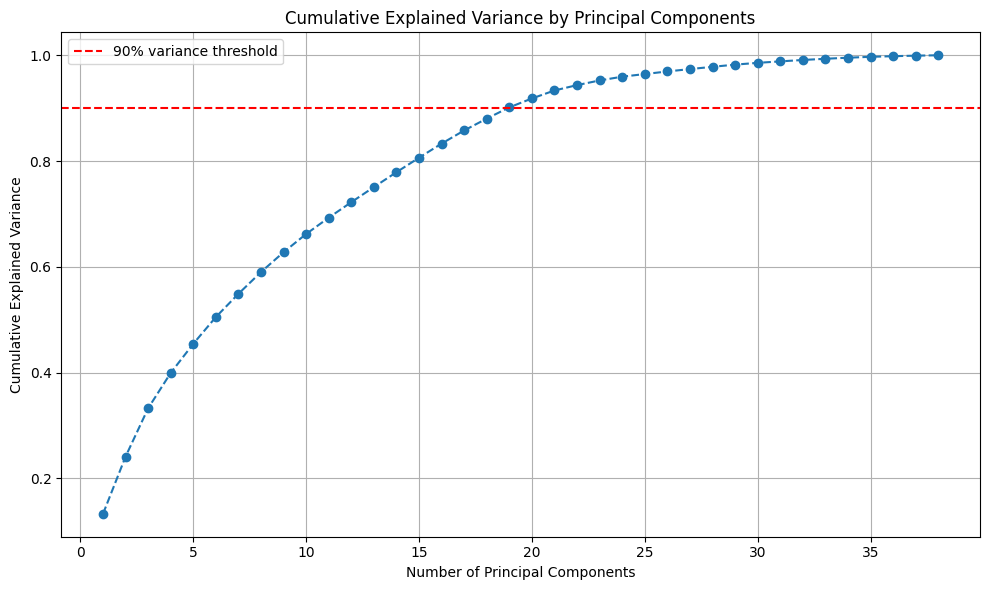

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Fit PCA on the final preprocessed dataset
pca = PCA()
pca.fit(df_final_cluster_ready)

# Explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.9, color='red', linestyle='--', label='90% variance threshold')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#Print the exact number to know how many components explain 90% variance in the data
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
print(f'Number of components needed to explain at least 90% variance: {n_components_90}')

Number of components needed to explain at least 90% variance: 19


From the code above we now know that it takes 18 components to reach 90% variance in the data

In [ ]:
# Apply PCA with 19 components
pca = PCA(n_components=19)
X_pca = pca.fit_transform(df_final_cluster_ready)

# Create a DataFrame for the transformed data with 19 columns
pca_columns = [f'PC{i+1}' for i in range(19)]
df_pca = pd.DataFrame(X_pca, columns=pca_columns)

# Attach SEQN for later merging (uncomment this)
df_pca['SEQN'] = combined_df.loc[df_final_cluster_ready.index, 'SEQN'].values

df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,SEQN
0,-2.962409,1.192029,0.373381,3.456913,-0.977227,0.412963,0.017562,2.175300,-0.098187,-0.190647,0.079646,0.359945,-0.306311,0.441451,-0.006320,0.499758,1.862222,0.633389,-0.175798,83736.0
1,-0.715710,0.055475,-0.582720,1.053466,-0.211983,1.110874,0.376635,-0.168798,0.756782,1.510328,-1.048946,1.220031,-1.187115,0.801731,0.769203,-0.027568,0.947333,-0.623366,0.027400,83745.0
2,-0.506835,-0.159455,0.111747,-0.725684,0.123819,0.603252,-0.181523,-0.314459,0.158640,1.356946,0.472301,0.019519,-0.022640,-0.000768,-0.541715,-0.440674,0.333925,0.255327,0.668923,83750.0
3,0.173121,0.782440,0.543461,0.325199,-0.130350,0.064872,0.357585,0.340696,-0.060917,1.124523,0.153218,-0.117507,-0.168446,0.010304,-0.438942,-0.246872,-0.533448,0.130487,0.094659,83754.0
4,0.413566,0.406611,-2.236534,-0.216608,-0.305129,-0.389172,0.143669,-0.128477,-0.923865,0.163277,-1.428605,0.146858,-0.220433,0.073411,0.139668,0.236982,0.134952,-0.037588,-0.414375,83762.0


To determine the best number of clusters we will run the following code below

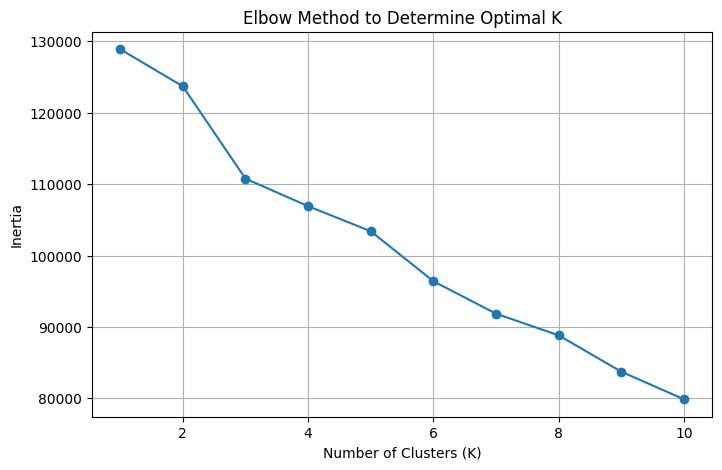

In [ ]:
from sklearn.cluster import KMeans

# Use the PCA-transformed data with 19 components
X = df_pca.iloc[:, :19]  # updated

# Elbow method: try K = 1 to 10 clusters
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Optimal K')
plt.grid(True)
plt.show()

In [ ]:
#Check explicit number for elbow in curve

from kneed import KneeLocator

kneedle = KneeLocator(k_values, inertia, curve='concave', direction='decreasing')
optimal_k = kneedle.knee
print("Optimal number of clusters (elbow):", optimal_k)

Optimal number of clusters (elbow): 10


In [ ]:
import numpy as np

inertia_diff = np.diff(inertia)
inertia_diff2 = np.diff(inertia_diff)

print("Second derivative of inertia:", inertia_diff2)

# Find index of maximum second derivative (biggest "bend")
elbow_index = np.argmax(inertia_diff2) + 2  # +2 to offset the double diff and zero-based indexing
print(f"Suggested optimal number of clusters based on second derivative: {elbow_index}")

Second derivative of inertia: [-7724.0669251   9071.92122863   336.13341821 -3481.79778457
  2452.75500396  1507.18821784 -2052.04452103  1225.78473859]
Suggested optimal number of clusters based on second derivative: 3


#Now we have the optimal number of clusters so time to actually cluster

cluster
1    2415
0    1744
2     144
Name: count, dtype: int64


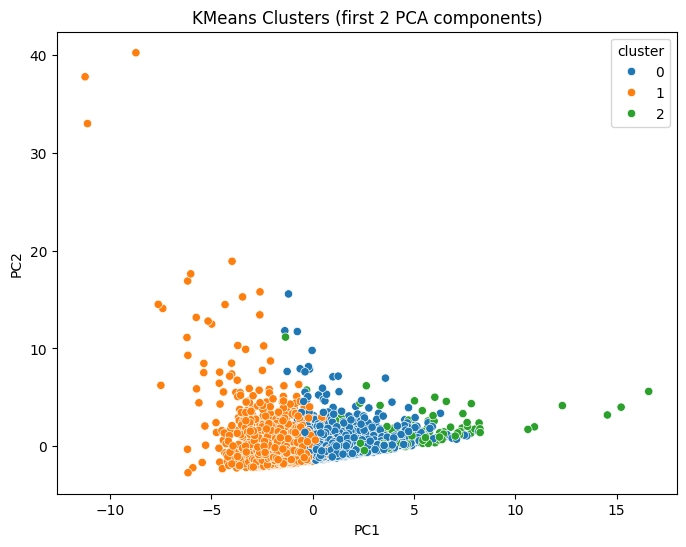

In [ ]:
# Use PCA-transformed data with 19 components
X = df_pca.iloc[:, :19]

# Run KMeans with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# Add cluster labels to df_pca
df_pca['cluster'] = cluster_labels

# Show count of points per cluster
print(df_pca['cluster'].value_counts())

# Visualize clusters in 2D using first two principal components
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette='tab10', legend='full')
plt.title('KMeans Clusters (first 2 PCA components)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [ ]:
# Copy to avoid modifying original
target_chd_clean = target_chd.copy()

# Drop rows with 9.0 or NaN in MCQ160C
target_chd_clean = target_chd_clean[target_chd_clean['MCQ160C'].isin([1.0, 2.0])]

# Map to binary: 1 = CHD diagnosed, 0 = not diagnosed
target_chd_clean['MCQ160C'] = target_chd_clean['MCQ160C'].map({1.0: 1, 2.0: 0})

# Check value counts after cleaning
print(target_chd_clean['MCQ160C'].value_counts())

MCQ160C
0    3356
1     150
Name: count, dtype: int64


In [ ]:
# Merge cluster labels with cleaned CHD target using SEQN
df_pca_with_chd = df_pca.merge(target_chd_clean, on='SEQN', how='inner')

# Group by cluster and calculate CHD prevalence (normalized value counts)
prevalence_by_cluster = (
    df_pca_with_chd.groupby('cluster')['MCQ160C']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
)

# Rename columns for clarity
prevalence_by_cluster.columns = ['No CHD', 'CHD']
prevalence_by_cluster = prevalence_by_cluster[['CHD', 'No CHD']]  # Optional: reorder

# Display prevalence table
print("CHD prevalence by cluster:")
print(prevalence_by_cluster)


CHD prevalence by cluster:
              CHD    No CHD
cluster                    
0        0.043195  0.956805
1        0.040597  0.959403
2        0.063830  0.936170


The cluster's aren't that different in CHD links. Cluster 2 has the highest prevalence by about 2%.

In [ ]:
# 1. Create profiling DataFrame including SEQN, cluster labels, and PCA components
df_profile = df_pca[['SEQN', 'cluster'] + [f'PC{i+1}' for i in range(19)]].copy()

# 2. Merge with the cleaned CHD target labels
df_profile = df_profile.merge(target_chd_clean, on='SEQN', how='inner')

# 3. Preview the merged profiling dataset
print("Shape of profiling dataset:", df_profile.shape)
df_profile.head()


Shape of profiling dataset: (3506, 22)


,SEQN,cluster,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,MCQ160C
0,83736.0,1,-2.962409,1.192029,0.373381,3.456913,-0.977227,0.412963,0.017562,2.175300,...,0.079646,0.359945,-0.306311,0.441451,-0.006320,0.499758,1.862222,0.633389,-0.175798,0
1,83750.0,1,-0.506835,-0.159455,0.111747,-0.725684,0.123819,0.603252,-0.181523,-0.314459,...,0.472301,0.019519,-0.022640,-0.000768,-0.541715,-0.440674,0.333925,0.255327,0.668923,0
2,83754.0,1,0.173121,0.782440,0.543461,0.325199,-0.130350,0.064872,0.357585,0.340696,...,0.153218,-0.117507,-0.168446,0.010304,-0.438942,-0.246872,-0.533448,0.130487,0.094659,0
3,83762.0,0,0.413566,0.406611,-2.236534,-0.216608,-0.305129,-0.389172,0.143669,-0.128477,...,-1.428605,0.146858,-0.220433,0.073411,0.139668,0.236982,0.134952,-0.037588,-0.414375,0
4,83767.0,0,1.980384,-0.442284,0.120636,0.036281,0.105473,1.199488,-0.045495,0.041111,...,0.473550,0.118124,-0.353011,0.186005,0.189665,-0.153170,0.132494,-0.559181,-0.506979,0


In [ ]:
# Calculate means of numeric features grouped by cluster
cluster_summary = df_profile.groupby('cluster').mean(numeric_only=True)

# Round for readability
cluster_summary = cluster_summary.round(2)

# Show top rows
cluster_summary.T  # transpose so features are rows

cluster,0,1,2
SEQN,93874.14,93191.02,93009.45
PC1,1.55,-1.15,4.62
PC2,0.17,-0.09,1.26
PC3,-0.92,0.33,5.15
PC4,-0.05,0.02,0.55
PC5,-0.06,-0.01,0.38
PC6,-0.18,0.11,1.17
PC7,-0.02,0.04,-0.19
PC8,-0.01,-0.01,0.27
PC9,-0.05,0.05,0.09


In [ ]:
# Create a DataFrame of PCA loadings
loadings = pd.DataFrame(pca.components_.T,
                        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
                        index=df_final_cluster_ready.columns)

# Display top contributing features for PC1 to PC3
for i in range(3):
    print(f"\nTop 5 features contributing to PC{i+1}:")
    print(loadings.iloc[:, i].abs().sort_values(ascending=False).head(5))


Top 5 features contributing to PC1:
BPXSY2    0.345550
BPXSY1    0.345549
BPXSY3    0.342155
BPXDI1    0.284485
BPXDI2    0.283111
Name: PC1, dtype: float64

Top 5 features contributing to PC2:
URXMOH     0.450091
URXMHH     0.446248
URXECP     0.421098
URXMHP     0.386657
URXHIBP    0.201746
Name: PC2, dtype: float64

Top 5 features contributing to PC3:
LBXPFDE    0.351969
LBXNFOS    0.334779
LBXPFNA    0.334391
LBXPFUA    0.326302
BPXDI2     0.291682
Name: PC3, dtype: float64


# Interpretation of the above code

The clustering revealed a small group (Cluster 2) with significantly higher environmental exposures (phthalates + PFAS) and blood pressure, which also showed the highest CHD prevalence. This suggests potential synergy between chemical exposure and hypertension in relation to CHD risk.

Another important finding is the significance of LBXNFOS to PC3. The feature represents n-perfluorooctane sulfonic acid which is commonly found in the creation of non-stickwear coatings and stain-resistant treatments for textiles and leather. When we preprocessed this was one of the features that was missing not at random in the 2013-2014 cycle likely because it was not collected. Our anticipation was that this feature and the other features not collected in 2013-2014 would be critical to our analysis and for that reason we dropped the 2013-2014 cycle from our modeling in order to lower the percentage of missing values of said features, allowing us to impute this lower missing percentage while lowering the risk of introducing bias to the dataset or ruining its integrity.

# **IGNORE THE CODE BELOW FOR NOW**

## Explore subgroups in cluster 3





In [ ]:
import pandas as pd
import os

# Define base path and cycles
base_path = '/content/drive/My Drive/Group 4'
cycles = {
    '2015-2016': 'NHANES 2015-2016 data/DEMO_I.xpt',
    '2017-2018': 'NHANES 2017-2018 data/DEMO_J.xpt'
}

# Load and store each demographic dataframe
demographic_dfs = []

for cycle, rel_path in cycles.items():
    full_path = os.path.join(base_path, rel_path)
    df = pd.read_sas(full_path, format='xport')
    df['cycle'] = cycle
    demographic_dfs.append(df)

# Concatenate into one dataframe
demographics_combined = pd.concat(demographic_dfs, ignore_index=True)

# Optional: filter for only the columns you need
demographic_features = [
    'SEQN',       # Always keep this to merge on
    'RIAGENDR',   # Gender
    'RIDAGEYR',   # Age
    'RIDRETH3',   # Race/ethnicity
    'DMQMILIZ',   # Active duty military
    'DMDBORN4',   # Country of birth
    'DMDEDUC2',   # Education level
    'DMDMARTL',   # Marital status
    'DMDHHSIZ',   # Household size
    'DMDHHSZE',   # Adults 60+ in household
    'DMDHRGND',   # Gender of household reference person
    'INDFMPIR'    # Income-to-poverty ratio
]

demographics_combined = demographics_combined[demographic_features]


In [ ]:
df_profile.shape

(3506, 22)

In [ ]:
demographics_combined.shape

(19225, 12)

In [ ]:
df_with_demo = df_profile.merge(demographics_combined, on='SEQN', how='left')

print(df_with_demo.shape)

(3506, 33)


In [ ]:
cluster_2 = df_with_demo[df_with_demo['cluster'] == 2]
print(f"Number of participants in Cluster 2: {cluster_2.shape[0]}")


Number of participants in Cluster 2: 141


In [ ]:
# Subset only Cluster 2 participants
cluster2 = df_profile[df_profile['cluster'] == 2]
print(cluster2.shape)

(141, 22)


In [ ]:
# Descriptive statistics for numerical demographic features
num_cols = ['RIDAGEYR', 'INDFMPIR', 'DMDHHSIZ', 'DMDHHSZE']
print(cluster_2[num_cols].describe())

# Value counts for categorical demographics
cat_cols = ['RIAGENDR', 'RIDRETH3', 'DMQMILIZ', 'DMDBORN4', 'DMDEDUC2', 'DMDMARTL', 'DMDHRGND']

for col in cat_cols:
    print(f"\n{col} value counts in Cluster 2:")
    print(cluster_2[col].value_counts(dropna=False))

         RIDAGEYR      INDFMPIR    DMDHHSIZ      DMDHHSZE
count  141.000000  1.180000e+02  141.000000  1.410000e+02
mean    60.737589  2.676271e+00    2.992908  1.106383e+00
std     13.764159  1.635916e+00    1.574332  8.510676e-01
min     26.000000  5.397605e-79    1.000000  5.397605e-79
25%     51.000000  1.185000e+00    2.000000  5.397605e-79
50%     62.000000  2.160000e+00    3.000000  1.000000e+00
75%     71.000000  4.400000e+00    4.000000  2.000000e+00
max     80.000000  5.000000e+00    7.000000  3.000000e+00

RIAGENDR value counts in Cluster 2:
RIAGENDR
2.0    73
1.0    68
Name: count, dtype: int64

RIDRETH3 value counts in Cluster 2:
RIDRETH3
6.0    61
4.0    41
3.0    24
2.0     7
1.0     5
7.0     3
Name: count, dtype: int64

DMQMILIZ value counts in Cluster 2:
DMQMILIZ
2.0    127
1.0     14
Name: count, dtype: int64

DMDBORN4 value counts in Cluster 2:
DMDBORN4
2.0     74
1.0     66
77.0     1
Name: count, dtype: int64

DMDEDUC2 value counts in Cluster 2:
DMDEDUC2
5.0    40

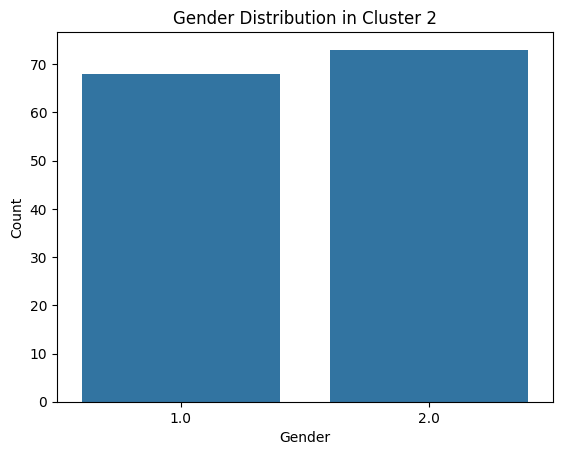

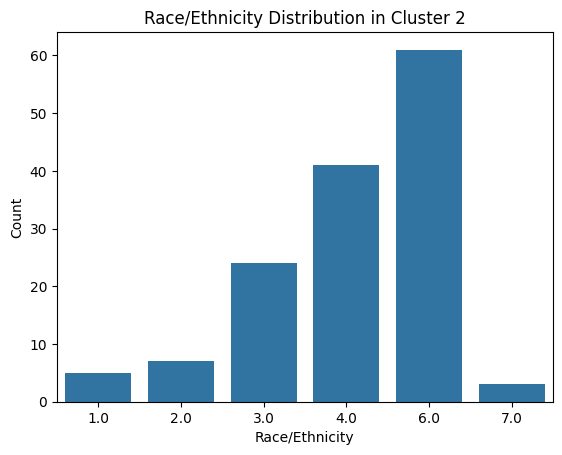

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot gender distribution
sns.countplot(data=cluster_2, x='RIAGENDR')
plt.title('Gender Distribution in Cluster 2')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# Plot race/ethnicity distribution
sns.countplot(data=cluster_2, x='RIDRETH3')
plt.title('Race/Ethnicity Distribution in Cluster 2')
plt.xlabel('Race/Ethnicity')
plt.ylabel('Count')
plt.show()